In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.metrics import roc_curve, auc

### **Step 1 : 建模**
##### M1 = 9447 ~ 9477 / M2 = 9477 ~ 9507 / M3 = 9507 ~ 9537 / M4 = 9537 ~ 9567

#### **1. 匯入所有商品30~60(m3)有無購買資料, 基本屬性資料, 網址資料**

In [4]:
fx_m3 = pd.read_csv('./data/fx_m3.csv')
cc_m3 = pd.read_csv('./data/cc_m3.csv')
ln_m3 = pd.read_csv('./data/ln_m3.csv')
wm_m3 = pd.read_csv('./data/wm_m3.csv')
cif_use = pd.read_csv('./data/cif_use.csv')
web_train = pd.read_csv('./data/web_train.csv')
# cif_use.drop(['CUST_START_DT'], axis = 1, inplace = True)

In [5]:
cif_use.shape

(187679, 7)

#### **2. 處理信用卡資料**

In [5]:
tb_cc = pd.read_csv('./data/TBN_CC_APPLY.csv')
tb_cc.rename(columns={'TXN_DT':'CC_DT'}, inplace = True)

In [6]:
# 計算30天以上,120天以內購買次數(m1~m3, 9447~9537)
cc_90 = tb_cc.loc[tb_cc['CC_DT'] <= 9537,['CUST_NO', 'CC_DT']]
cc_90.reset_index(drop=True, inplace=True)
cc_90['CC_DT'] = 1
cc_90 = cc_90.groupby('CUST_NO').sum().reset_index(level=0)
cc_90.columns = ['CUST_NO','CC_count']

In [7]:
# 篩出0~30天(m4)有無購買(Y)
tb_cc['CC_Y'] = [1 if i >= 9537 else 0 for i in tb_cc['CC_DT']]
cc_y = tb_cc.loc[tb_cc['CC_Y'] == 1,['CUST_NO', 'CC_Y']].drop_duplicates(subset = 'CUST_NO')

In [8]:
# 合併cc所需資料
cc_train = cc_90.merge(cc_y, on = 'CUST_NO', how = 'left')
cc_train = cc_train.fillna(0)

#### **3. 以基本屬性為底,合併網址、信用卡、其他商品m3有無購買之資料**

In [9]:
cc_forecast = cif_use.merge(web_train, on = 'CUST_NO', how = 'left').merge(cc_train, on = 'CUST_NO', how = 'left').merge(cc_m3, on = 'CUST_NO', how = 'left')\
.merge(fx_m3, on = 'CUST_NO', how = 'left').merge(ln_m3, on = 'CUST_NO', how = 'left').merge(wm_m3, on = 'CUST_NO', how = 'left')

In [10]:
cc_forecast = cc_forecast.fillna(0)
cc_forecast_list = [i for i in cc_forecast.columns if i !='CUST_NO' and i!='GENDER_CODE' and i != 'AGE']
cc_forecast[cc_forecast_list] = cc_forecast[cc_forecast_list].apply(lambda x:x.astype(int))

In [11]:
cc_forecast.head()

,CUST_NO,AGE,CHILDREN_CNT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,web_1,web_2,web_3,web_4,web_5,web_6,web_7,CC_count,CC_Y,CC_30,FX_30,LN_30,WM_30
0,UFUIMEGMK2KTIWI4,1,0,4,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3HJN2X_LGBHBKILI,3,0,4,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MNEZK2O3OE-JHYBW,4,0,3,0.0,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,W7ADZSWYXEMHB7JQ,4,0,5,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ODB6BA6ORHL2UYZE,4,0,3,0.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 4. **決策樹**

In [12]:
X = cc_forecast.drop(['CUST_NO', 'CC_Y'], axis = 1)
Y = cc_forecast['CC_Y']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30,random_state=0)

In [13]:
print('X_train :',X_train.shape)
print('Y_train', Y_train.shape)
print('X_test :', X_test.shape)
print('Y_test', Y_test.shape)

X_train : (131375, 18)
Y_train (131375,)
X_test : (56304, 18)
Y_test (56304,)


In [14]:
X_train.columns

Index(['AGE', 'CHILDREN_CNT', 'EDU_CODE', 'GENDER_CODE', 'INCOME_RANGE_CODE',
       'WORK_MTHS', 'web_1', 'web_2', 'web_3', 'web_4', 'web_5', 'web_6',
       'web_7', 'CC_count', 'CC_30', 'FX_30', 'LN_30', 'WM_30'],
      dtype='object')

In [15]:
cc_tree = DecisionTreeClassifier(criterion = "entropy",
                                 max_depth=3, min_samples_leaf=5)
cc_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
cc_predict = cc_tree.predict(X_test)

In [17]:
pd.Series(cc_predict.tolist()).value_counts()

0    56304
dtype: int64

In [18]:
# print(classification_report(Y_test,fx_predict))
print("Accuracy is ", accuracy_score(Y_test, cc_predict)*100)
# print(confusion_matrix(y_test,predictions))

Accuracy is  99.52401250355216


<Figure size 432x288 with 0 Axes>

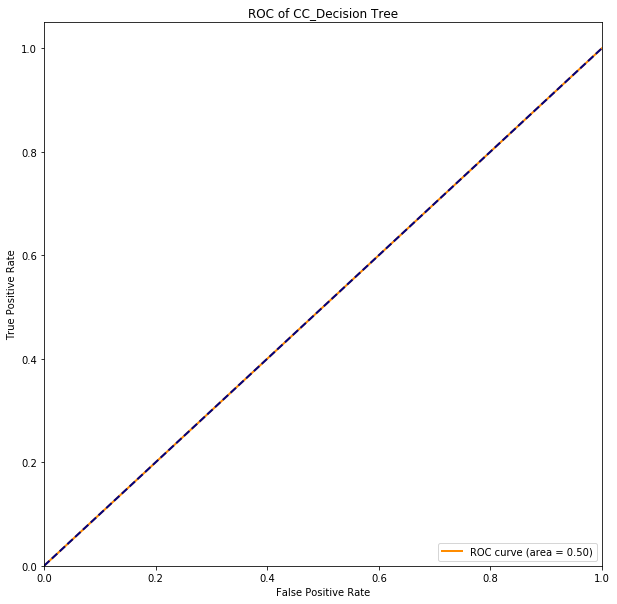

In [19]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test, cc_predict) ###計算True Postive 和 False Positive
roc_auc = auc(fpr,tpr) ###計算AUC
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of CC_Decision Tree')
plt.legend(loc="lower right")
plt.show()

#### **5. 隨機森林**

In [20]:
from sklearn import cross_validation, ensemble, preprocessing, metrics

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
cc_forest = ensemble.RandomForestClassifier(n_estimators = 100)
cc_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
cc_f_predict = cc_forest.predict(X_test)

In [23]:
accuracy = metrics.accuracy_score(Y_test, cc_f_predict)
print(accuracy)

0.9949914748508099


In [24]:
print("Accuracy is ", metrics.accuracy_score(Y_test, cc_f_predict)*100)

Accuracy is  99.49914748508098


<Figure size 432x288 with 0 Axes>

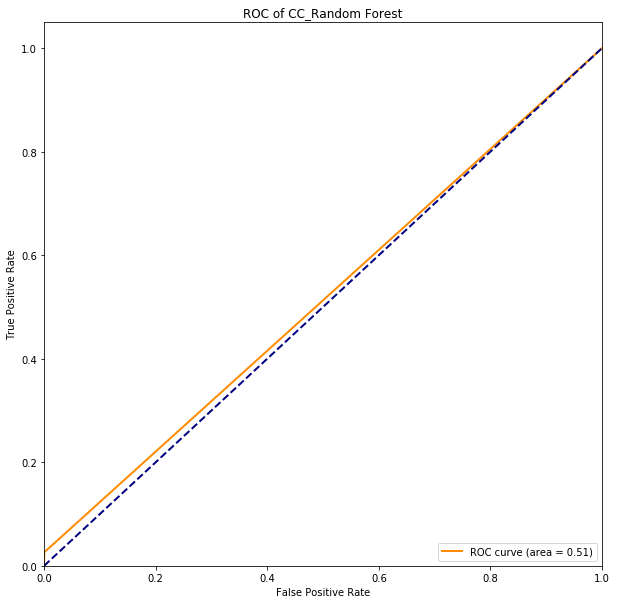

In [25]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test, cc_f_predict) ###計算True Postive 和 False Positive 
roc_auc = auc(fpr,tpr) ###計算AUC
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of CC_Random Forest')
plt.legend(loc="lower right")
plt.show()

#### **6. XGBoost**

In [26]:
from xgboost import XGBClassifier

In [27]:
xgb = XGBClassifier()

In [28]:
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
cc_xgb_predict = xgb.predict(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
print("Accuracy is ", accuracy_score(Y_test, cc_xgb_predict)*100)

Accuracy is  99.52401250355216


<Figure size 432x288 with 0 Axes>

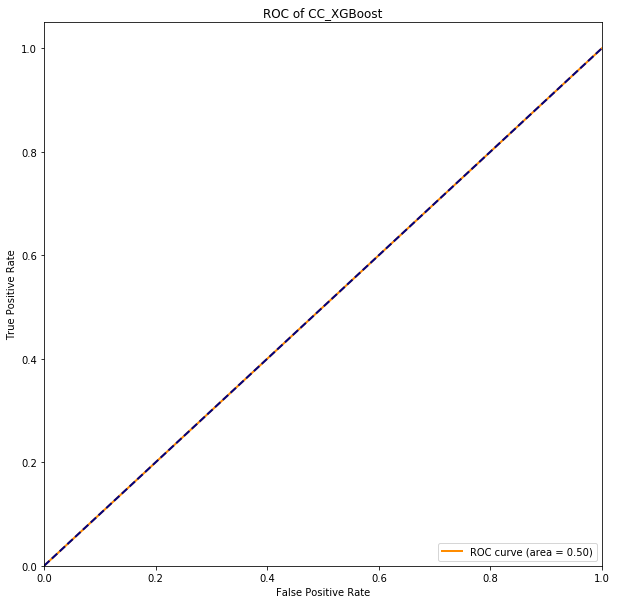

In [31]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test, cc_xgb_predict) ###計算True Postive 和 False Positive 
roc_auc = auc(fpr,tpr) ###計算AUC
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###False Postive為橫軸，True Postive為縱軸
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of CC_XGBoost')
plt.legend(loc="lower right")
plt.show()

### **Step 2 : Load 預測資料集**

In [32]:
Y_zero  = pd.read_csv('./data/TBN_Y_ZERO.csv')
# Y_zero  = pd.read_csv('./data/TBN_Y_ZERO.csv', usecols = ['CUST_NO', 'FX_IND'])

#### **1. 匯入所有商品0~30(m4)有無購買,網址資料(m3,m4)**

In [37]:
fx_m4 = pd.read_csv('./data/fx_m4.csv')
cc_m4 = pd.read_csv('./data/cc_m4.csv')
ln_m4 = pd.read_csv('./data/ln_m4.csv')
wm_m4 = pd.read_csv('./data/wm_m4.csv')
web_test = pd.read_csv('./data/web_test.csv')

In [38]:
web_test.shape

(106655, 8)

#### **2. 處理信用卡資料**

In [39]:
# 計算0~90天以內購買次數(m2~m4, 9477~9567)
cc_test = tb_cc.loc[tb_cc['CC_DT'] > 9477,['CUST_NO', 'CC_DT']]
cc_test.reset_index(drop=True, inplace=True)
cc_test['CC_DT'] = 1
cc_test = cc_test.groupby('CUST_NO').sum().reset_index(level=0)
cc_test.columns = ['CUST_NO','CC_count']

#### **3. 以Y為底，合併基本屬性,網址、外匯、其他商品m4有無購買之資料**

In [40]:
Y_cc = Y_zero[['CUST_NO']].merge(cif_use, on = 'CUST_NO', how = 'left').merge(web_test, on = 'CUST_NO', how = 'left').merge(cc_test, on = 'CUST_NO', how = 'left')\
.merge(cc_m4, on = 'CUST_NO', how = 'left').merge(fx_m4, on = 'CUST_NO', how = 'left').merge(ln_m4, on = 'CUST_NO', how = 'left').merge(wm_m4, on = 'CUST_NO', how = 'left')

In [41]:
Y_cc.loc[Y_cc['GENDER_CODE'].isnull(),:].shape

(146, 19)

##### **3.1 處裡基本屬性資料**

In [46]:
Y_cc.isnull().any()

CUST_NO              False
AGE                  False
CHILDREN_CNT         False
EDU_CODE             False
GENDER_CODE          False
INCOME_RANGE_CODE    False
WORK_MTHS            False
web_1                False
web_2                False
web_3                False
web_4                False
web_5                False
web_6                False
web_7                False
CC_count             False
CC_30                False
FX_30                False
LN_30                False
WM_30                False
dtype: bool

In [43]:
m_edu = round(Y_cc.loc[:,'EDU_CODE'].mean())
m_income = round(Y_cc.loc[:, 'INCOME_RANGE_CODE'].mean())
m_work = round(Y_cc.loc[:, 'WORK_MTHS'].mean())
m_age = round(Y_cc.loc[:, 'AGE'].mean())
name_ = Y_cc.columns.tolist()[1:7]
mean_ = [m_age, 0, m_edu, 2, m_income, m_work] 
for i,j in zip(name_, mean_):
    Y_cc.loc[:,i] = Y_cc.loc[:, i].fillna(j)

In [45]:
Y_cc = Y_cc.fillna(0)
Y_cc_list = [i for i in Y_cc.columns if i !='CUST_NO']
Y_cc[Y_cc_list] = Y_cc[Y_cc_list].apply(lambda x:x.astype(int))

#### **4. 決策樹**

In [47]:
X_train = cc_forecast.drop(['CUST_NO', 'CC_Y'], axis = 1)
Y_train = cc_forecast['CC_Y']
X_test = Y_cc.drop(['CUST_NO'], axis = 1)

In [48]:
print('X_train :',X_train.shape)
print('Y_train', Y_train.shape)
print('X_test :', X_test.shape)
# print('Y_test', Y_test.shape)

X_train : (187679, 18)
Y_train (187679,)
X_test : (30000, 18)


In [50]:
cc_tree = DecisionTreeClassifier(criterion = "entropy",
                               max_depth=3, min_samples_leaf=5)
cc_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
cc_predict = cc_tree.predict(X_test).tolist()

In [29]:
# pd.Series(cc_predict.tolist()).value_counts()

In [52]:
Y_zero['CC_IND'] = cc_predict

In [43]:
# Y_zero[Y_zero['CC_IND'] == 0]

In [53]:
TBN_Y_CC = Y_zero.loc[:,['CUST_NO', 'CC_IND']]
TBN_Y_CC.head()
TBN_Y_CC.to_csv('./data/TBN_Y_CC_D_30.csv', index = False)

##### **隨機森林**

In [54]:
X_train = cc_forecast.drop(['CUST_NO', 'CC_Y'], axis = 1)
Y_train = cc_forecast['CC_Y']
X_test = Y_cc.drop(['CUST_NO'], axis = 1)

In [55]:
cc_forest = ensemble.RandomForestClassifier(n_estimators = 100)
cc_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
cc_f_predict = cc_forest.predict(X_test)

In [57]:
Y_zero['CC_IND'] = cc_f_predict

In [58]:
TBN_Y_CC = Y_zero.loc[:,['CUST_NO', 'CC_IND']]
TBN_Y_CC.head()
TBN_Y_CC.to_csv('./data/TBN_Y_CC_Forest_30.csv', index = False)

##### **XGBOOST**

In [59]:
xgb = XGBClassifier()

In [60]:
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
cc_xgb_predict = xgb.predict(X_test).tolist()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
Y_zero['CC_IND'] = cc_xgb_predict

In [63]:
TBN_Y_CC = Y_zero.loc[:,['CUST_NO', 'CC_IND']]
TBN_Y_CC.head()
TBN_Y_CC.to_csv('./data/TBN_Y_CC_XGB_30.csv', index = False)